### Play around with dPCA
- Do things per feature
- parameters would be: 
  - feedback response: correct/incorrect
  - feature choice: chosen, not chosen
- start with trial-averaged PSTHs, concated across sessions
- interested in: 
  - how much variance does interaction component explain?
  - what does decoding look like for neural activity projected into that subspace?
  - is there a more significant difference between preferred/non-preferred

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy

### Generate trial-averaged PSTHs across sessions, for some feature. 
- df with columns: pseudo unit id, time_bin, response, choice, firing_rate

In [2]:
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sub}/{sess_name}_{fr_type}_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

def trial_average_data(row, feat, columns, trial_interval, mean_sub=False):
    """
    return df with columns: pseudo unit id, time_bin, response, choice, firing_rate
    """
    sess_name = row.session_name
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess("SA", sess_name)
    beh = behavioral_utils.get_chosen_single(feat, beh)
    spikes_path = SESS_SPIKES_PATH.format(
        sub="SA",
        sess_name=sess_name, 
        fr_type="firing_rates",
        pre_interval=trial_interval.pre_interval, 
        event=trial_interval.event, 
        post_interval=trial_interval.post_interval, 
        interval_size=trial_interval.interval_size
    )
    frs = pd.read_pickle(spikes_path)
    frs["PseudoUnitID"] = int(sess_name) * 100 + frs.UnitID.astype(int)

    merged = pd.merge(frs, beh, on="TrialNumber")
    trial_averaged = merged.groupby(["PseudoUnitID", "TimeBins"] + columns).FiringRate.mean().reset_index(name="FiringRate")
    if mean_sub: 
        means = trial_averaged.groupby("PseudoUnitID").FiringRate.mean().reset_index(name="FiringRateMean")
        trial_averaged = pd.merge(trial_averaged, means, on="PseudoUnitID")
        trial_averaged["FiringRate"] = trial_averaged.FiringRate - trial_averaged.FiringRateMean
    return trial_averaged[["PseudoUnitID", "TimeBins", "FiringRate"] + columns]


In [3]:
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
feat = "TRIANGLE"
feat_sessions = pd.read_pickle(FEATS_PATH)
valid_sess = pd.read_pickle(SESSIONS_PATH)
row = feat_sessions[feat_sessions.feat == feat].iloc[0]
sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]

In [23]:
TrialInterval = namedtuple('TrialInterval', ['event', 'pre_interval', 'post_interval', 'interval_size'])
interval = TrialInterval("FeedbackOnset", 1800, 1500, 100)
trial_averaged = pd.concat(sessions.apply(lambda x: trial_average_data(x, feat, ["Response", "Choice"], interval, mean_sub=False), axis=1).values)
# just fb times: 
trial_averaged = trial_averaged[trial_averaged.TimeBins >= 1.8]
trial_averaged = trial_averaged[trial_averaged.PseudoUnitID.isin([2018080330, 2018080615, 2018080119, 2018080232, 2018080107,
       2018092509, 2018092623, 2018100905, 2018080113, 2018080129,
       2018092600, 2018061508, 2018092526, 2018092521, 2018092508,
       2018092519, 2018100501, 2018080105, 2018080116, 2018080621])]

In [24]:
# transform into np array of n_units, n_time_bins, n_choices, n_responses
np_arr = trial_averaged.sort_values(by=["PseudoUnitID", "TimeBins", "Choice", "Response"]).FiringRate.to_numpy()
data = np_arr.reshape(
    trial_averaged.PseudoUnitID.nunique(), 
    trial_averaged.TimeBins.nunique(), 
    trial_averaged.Choice.nunique(), 
    trial_averaged.Response.nunique()
)

In [25]:
data.shape

(20, 15, 2, 2)

### Try out dPCA

In [26]:
from dPCA import dPCA

In [27]:
dpca = dPCA.dPCA(
    labels="tcr",
    join={
        "tc": ["c", "tc"],
        "tr": ["r", "tr"],
        "tcr": ["cr", "tcr"],
    },
    regularizer=None
)

dpca.protect = ['t']

In [28]:
res = dpca.fit_transform(data, data)

In [29]:
res.keys()

dict_keys(['t', 'tc', 'tr', 'tcr'])

In [30]:
dpca.explained_variance_ratio_["tcr"]

[0.010082627832322793,
 0.0017327017357617036,
 0.00115293230345078,
 0.00047856798142546076,
 8.980317275636422e-05,
 1.7065313869634124e-05,
 8.668771179506226e-06,
 5.357203514895355e-07,
 4.067521868687972e-08,
 9.078484872177126e-09]

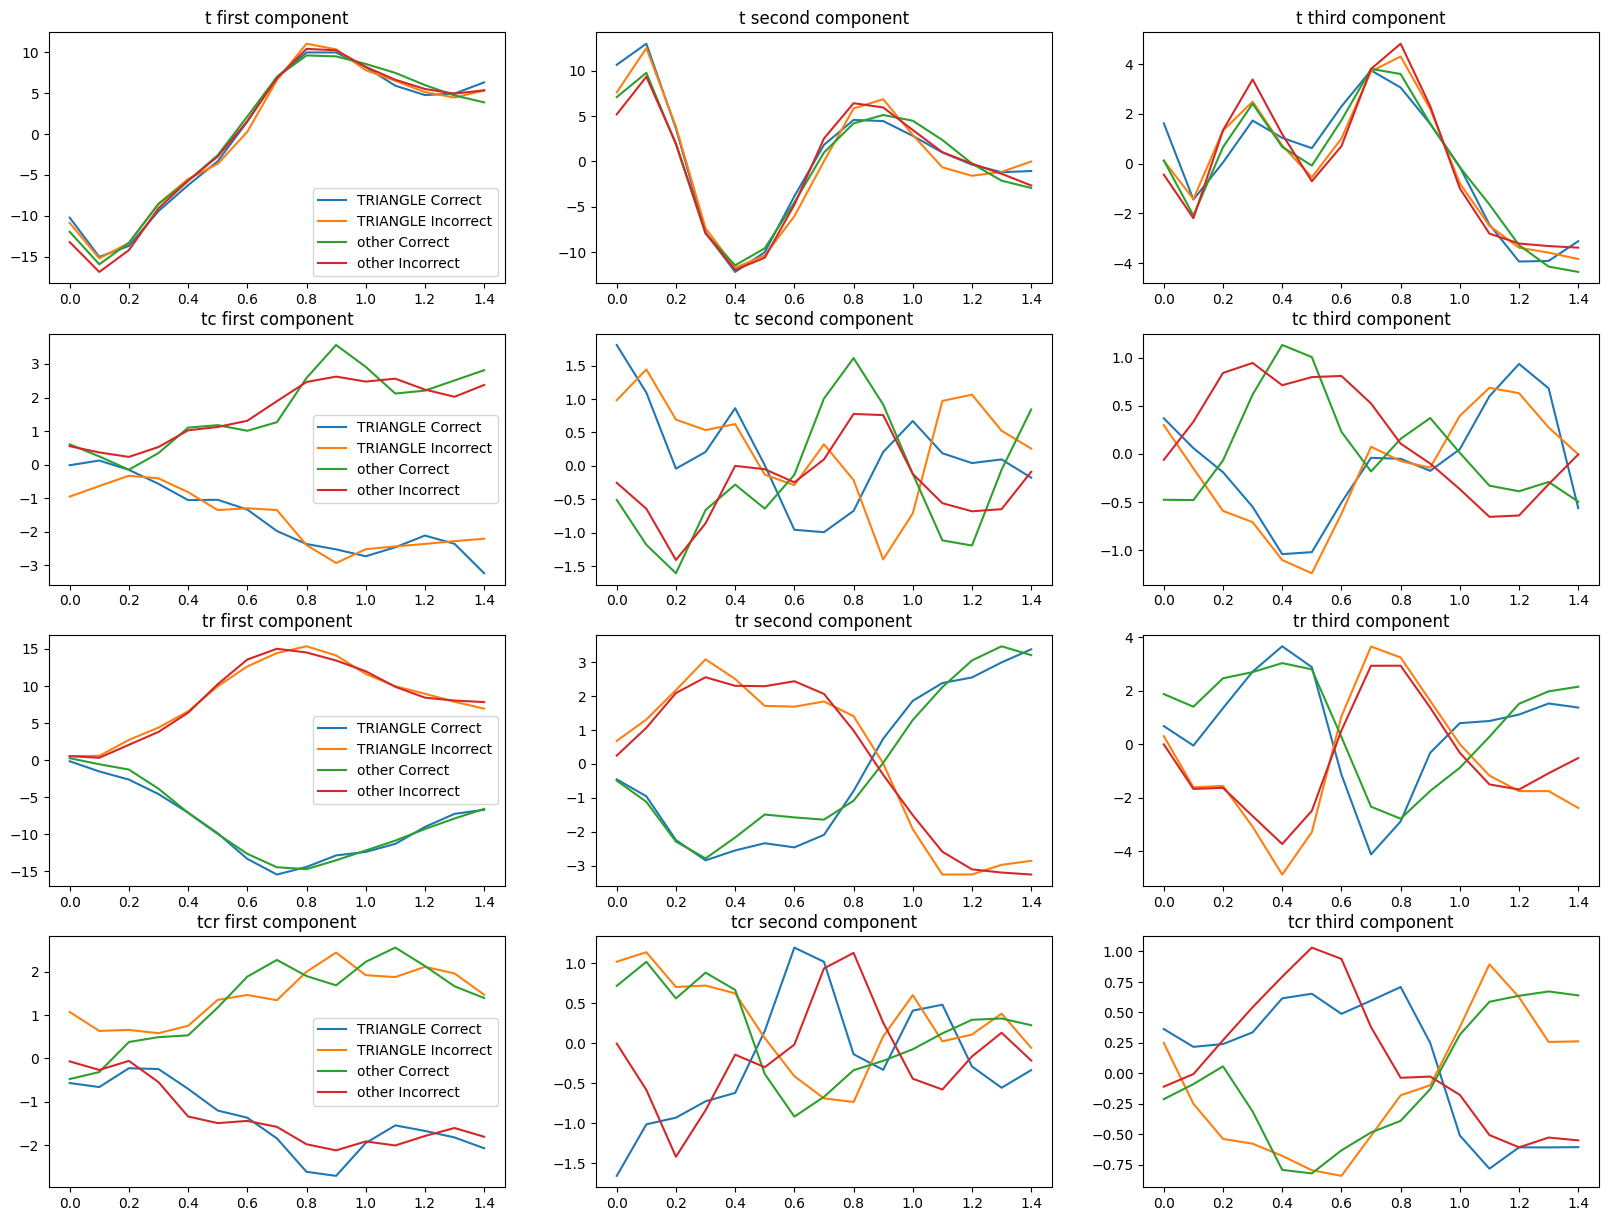

In [31]:
fig, axs = plt.subplots(len(res.keys()), 3, figsize=(20, 15))
x = np.arange(0, 1.5, 0.1)
for comp_idx, comp in enumerate(res):
    mat = res[comp]
    for choice_idx, choice in enumerate([feat, "other"]):
        for response_idx, response in enumerate(["Correct", "Incorrect"]):
            axs[comp_idx, 0].plot(x, mat[0, :, choice_idx, response_idx], label=f"{choice} {response}")
            axs[comp_idx, 1].plot(x, mat[1, :, choice_idx, response_idx], label=f"{choice} {response}")
            axs[comp_idx, 2].plot(x, mat[2, :, choice_idx, response_idx], label=f"{choice} {response}")

            axs[comp_idx, 0].legend()
            axs[comp_idx, 0].set_title(f"{comp} first component")
            axs[comp_idx, 1].set_title(f"{comp} second component")
            axs[comp_idx, 2].set_title(f"{comp} third component")

### Try to hand calc the anova factors...

In [5]:
trial_averaged

,PseudoUnitID,TimeBins,FiringRate,Response,Choice
72,2018080600,1.8,23.284997,Correct,TRIANGLE
73,2018080600,1.8,22.973775,Correct,other
74,2018080600,1.8,23.707812,Incorrect,TRIANGLE
75,2018080600,1.8,23.431318,Incorrect,other
76,2018080600,1.9,20.996680,Correct,TRIANGLE
...,...,...,...,...,...
5143,2018061538,3.1,2.534456,Incorrect,other
5144,2018061538,3.2,2.882097,Correct,TRIANGLE
5145,2018061538,3.2,2.960158,Correct,other
5146,2018061538,3.2,2.591739,Incorrect,TRIANGLE


In [6]:
def compute_average_over(df, value_col, groupby_cols, name):
    avg = df.groupby(groupby_cols)[value_col].mean().reset_index(name=name)
    return pd.merge(df, avg, on=groupby_cols)
    

In [7]:
total_var = np.sum(trial_averaged.FiringRate ** 2)
print(total_var)

2459532.648568309


In [8]:
df = compute_average_over(trial_averaged, "FiringRate", ["PseudoUnitID"], "x")

In [9]:
df["subbed"] = df.FiringRate - df.x
df = compute_average_over(df, "subbed", ["PseudoUnitID", "TimeBins"], "x_t")
df = compute_average_over(df, "subbed", ["PseudoUnitID", "Response"], "x_r")
df = compute_average_over(df, "subbed", ["PseudoUnitID", "Choice"], "x_c")

In [10]:
df["subbed"] = df.FiringRate - df.x - df.x_t - df.x_r - df.x_c
df = compute_average_over(df, "subbed", ["PseudoUnitID", "TimeBins", "Response"], "x_tr")
df = compute_average_over(df, "subbed", ["PseudoUnitID", "TimeBins", "Choice"], "x_tc")
df = compute_average_over(df, "subbed", ["PseudoUnitID", "Response", "Choice"], "x_rc")

In [11]:
df["subbed"] = df.FiringRate - df.x - df.x_t - df.x_r - df.x_c - df.x_tr - df.x_tc - df.x_rc
df = compute_average_over(df, "subbed", ["PseudoUnitID", "TimeBins", "Response", "Choice"], "x_trc")


In [12]:
df["subbed"] = df.FiringRate - df.x - df.x_t - df.x_r - df.x_c - df.x_tr - df.x_tc - df.x_rc - df.x_trc


assert variance sums up

In [13]:
sum = 0.0
total_var = df.FiringRate.var()
for col in ["x", "x_t", "x_r", "x_c", "x_tr", "x_tc", "x_rc", "x_trc"]:
    var_frac = df[col].var() / total_var
    print(f"{col}: {var_frac}")
    sum += var_frac
print(sum)

x: 0.9019336622855963
x_t: 0.061855577035015874
x_r: 0.020047313421597338
x_c: 0.0006989560626578979
x_tr: 0.013807121450988162
x_tc: 0.0009973811317620352
x_rc: 0.0002354571420131695
x_trc: 0.00042453147036934907
1.0000000000000002


assert variance sums up per unit

In [14]:
def cal_unit_var(unit_df):
    row = {}
    sum = 0.0
    total_var = unit_df.FiringRate.var()
    row["total_var"] = total_var
    for col in ["x", "x_t", "x_r", "x_c", "x_tr", "x_tc", "x_rc", "x_trc"]:
        var_frac = unit_df[col].var() / total_var
        row[f"{col}_var_frac"] = var_frac
        sum += var_frac
    row["sum_var_frace"] = sum
    return pd.Series(row)

unit_vars = df.groupby("PseudoUnitID").apply(cal_unit_var).reset_index()
unit_vars["interaction_frac"] = unit_vars.x_rc_var_frac + unit_vars.x_trc_var_frac

In [15]:
unit_vars

,PseudoUnitID,total_var,x_var_frac,x_t_var_frac,x_r_var_frac,x_c_var_frac,x_tr_var_frac,x_tc_var_frac,x_rc_var_frac,x_trc_var_frac,sum_var_frace,interaction_frac
0,2018061500,2.403832,3.337302e-31,0.842332,0.000193,0.007961,0.123026,0.021216,0.000037,0.005236,1.0,0.005273
1,2018061501,2.359564,8.499784e-32,0.849720,0.032758,0.000518,0.098462,0.005219,0.006855,0.006468,1.0,0.013323
2,2018061502,10.196738,3.147012e-31,0.384190,0.029064,0.000033,0.572358,0.007952,0.001257,0.005147,1.0,0.006404
3,2018061503,0.105655,1.186397e-31,0.811757,0.006392,0.004649,0.057350,0.086777,0.001242,0.031832,1.0,0.033074
4,2018061504,28.574801,4.491966e-31,0.548858,0.124120,0.000964,0.318529,0.000709,0.002967,0.003852,1.0,0.006819
...,...,...,...,...,...,...,...,...,...,...,...,...
348,2018100911,7.440119,1.725201e-30,0.522339,0.006763,0.000284,0.445224,0.008827,0.004222,0.012341,1.0,0.016563
349,2018100912,5.590817,1.434909e-31,0.792479,0.064323,0.000052,0.126714,0.009492,0.001542,0.005398,1.0,0.006940
350,2018100913,0.162030,3.094452e-31,0.764534,0.023257,0.009192,0.081229,0.067225,0.038188,0.016376,1.0,0.054564
351,2018100914,0.263842,7.601445e-31,0.050925,0.061870,0.031841,0.114830,0.334409,0.184691,0.221434,1.0,0.406125


In [25]:
interesting_units = unit_vars.sort_values(by="interaction_frac", ascending=False)[:20].PseudoUnitID

### Choose 10 random units, plot firing rate by choice, response

In [26]:
trial_averaged["condition"] = trial_averaged.Response + trial_averaged.Choice

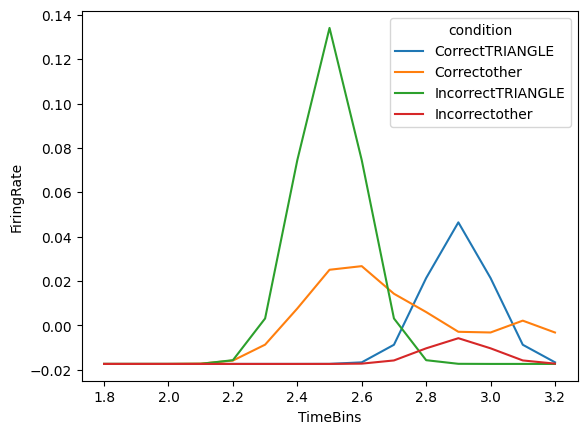

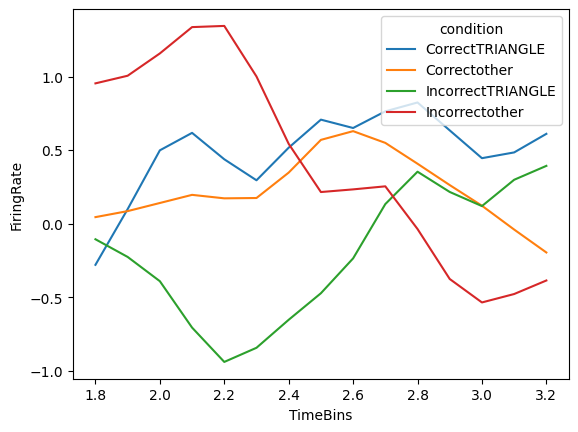

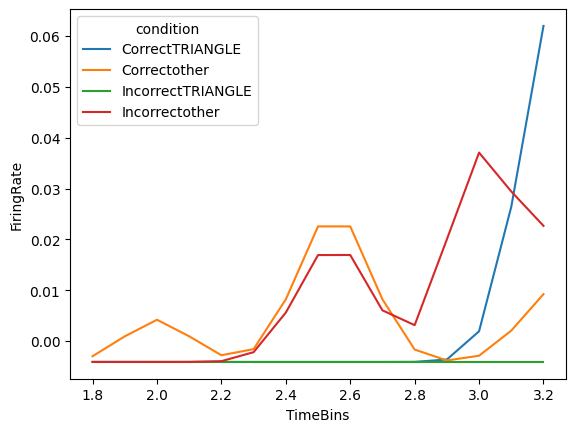

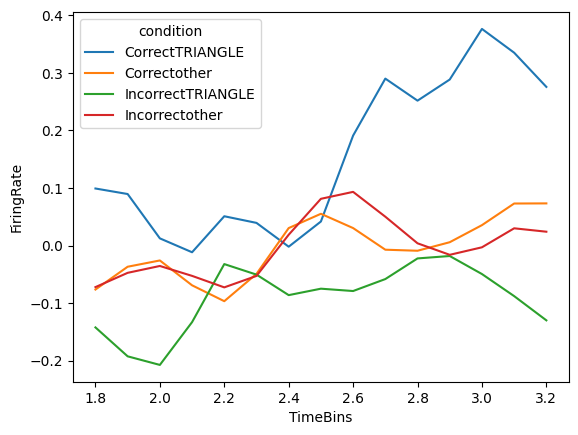

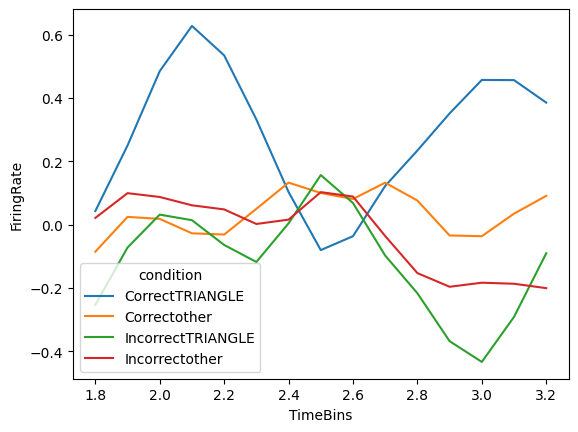

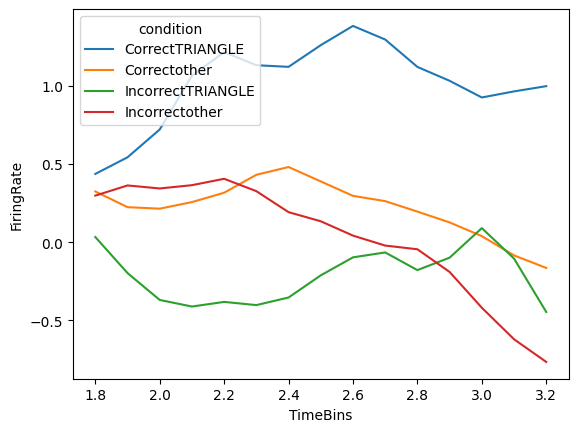

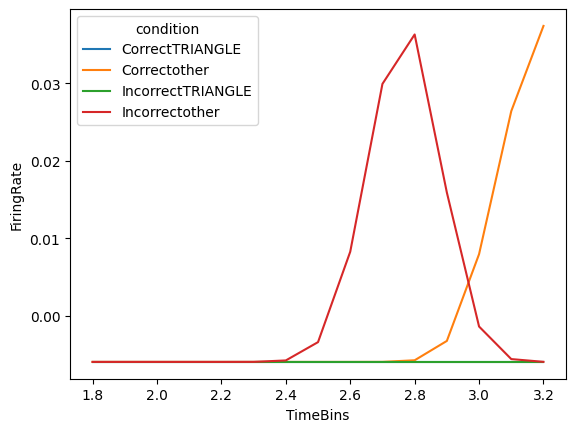

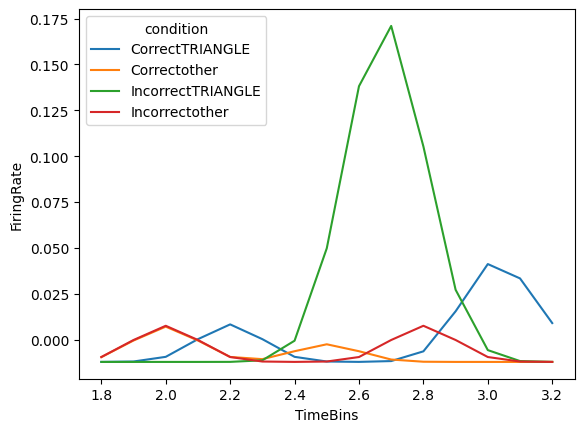

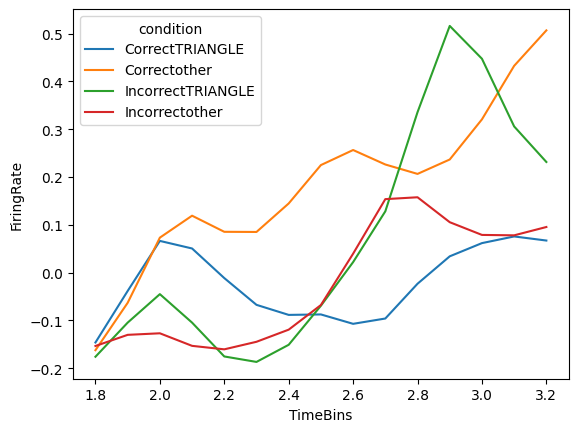

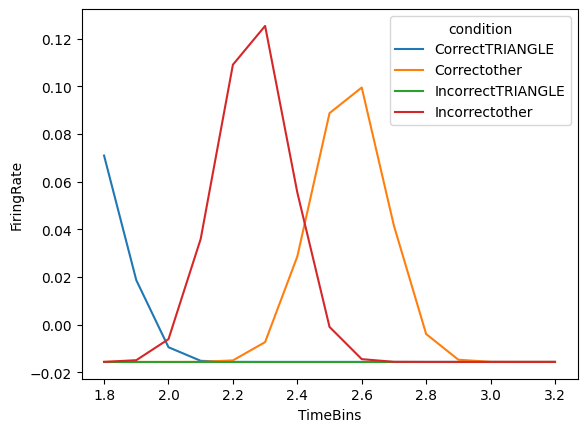

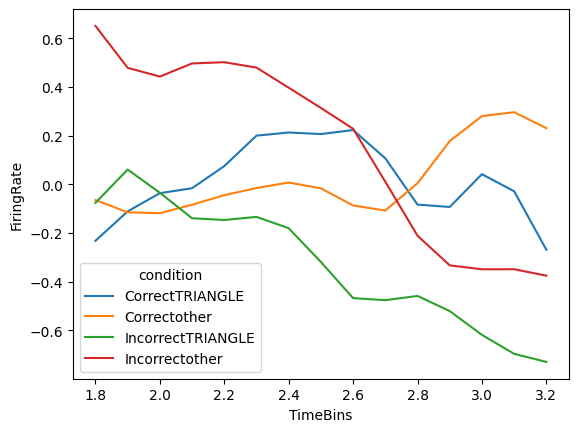

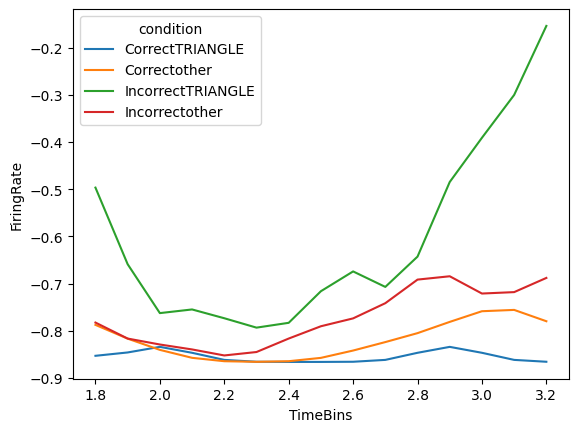

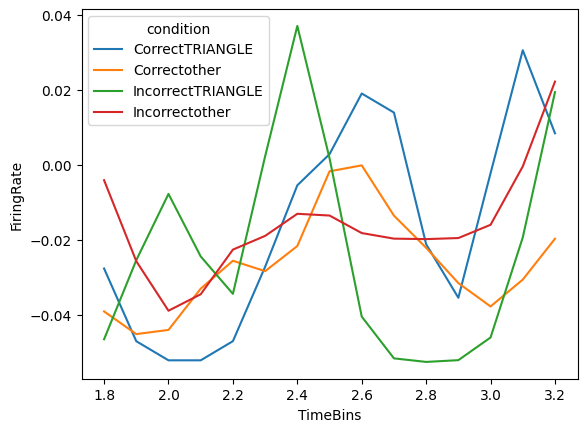

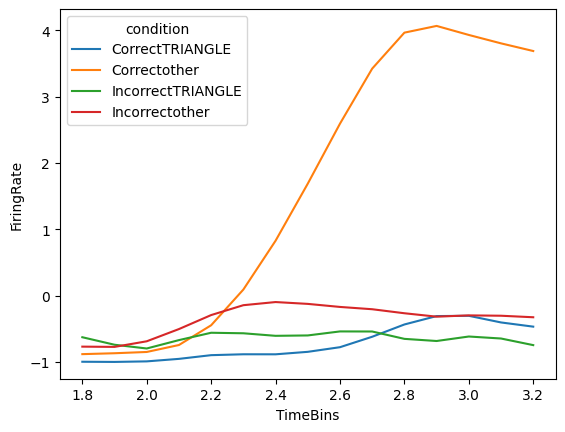

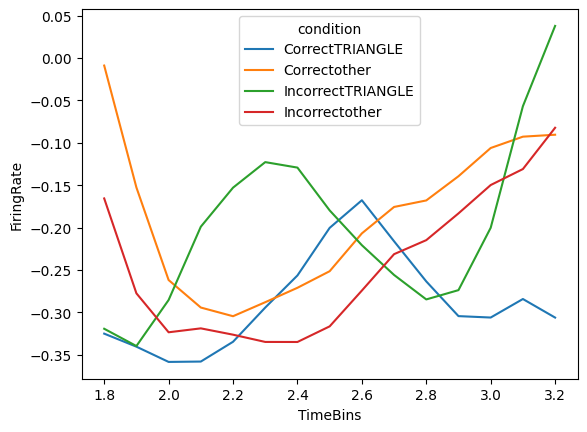

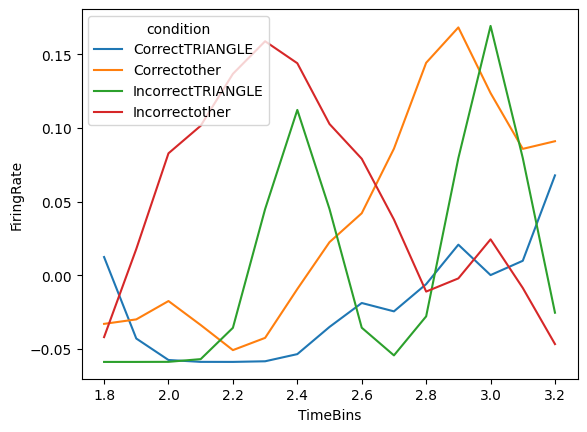

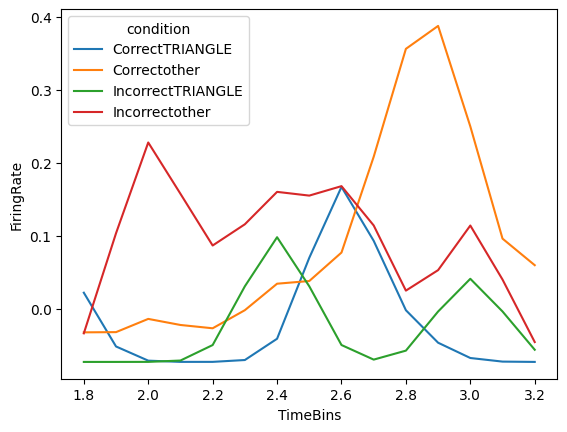

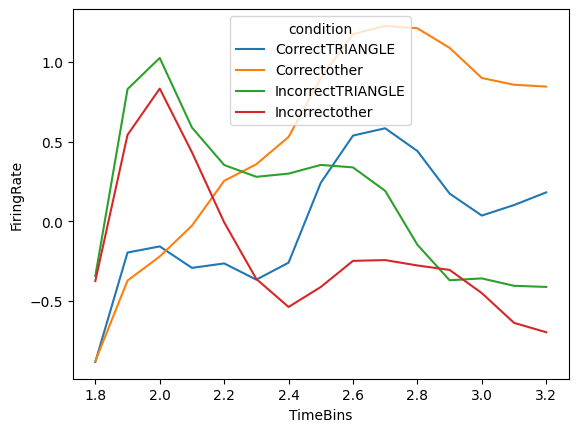

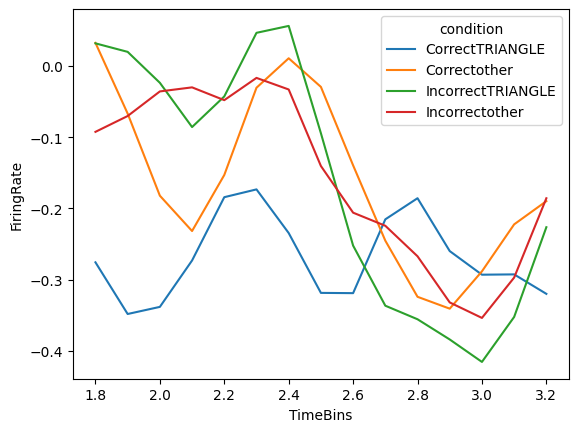

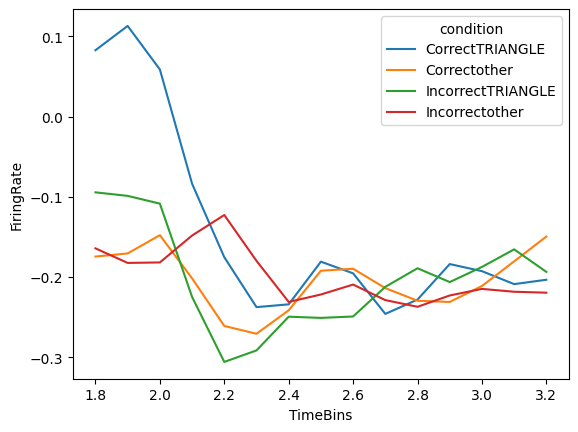

In [27]:

for unit in interesting_units:
    unit_ex = trial_averaged[trial_averaged.PseudoUnitID == unit]
    fig, ax = plt.subplots()
    sns.lineplot(unit_ex, x="TimeBins", y="FiringRate", hue="condition", ax=ax)